In [1]:
import numpy as np
import pandas as pd
import pywt
import matplotlib.pyplot as plt
import yfinance as yf


/Users/nuzzo2/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:

class WaveletAnalyzer:
    def __init__(self):
        self.data = None
        self.coefficients = None
        self.reconstructed = None
        
    def fetch_data(self, ticker, start='2020-01-01'):
        """Fetch and prepare price data"""
        df = yf.download(ticker, start=start)
        self.data = df['Adj Close']
        return self.data
    
    def decompose(self, wavelet='db1', level=4):
        """
        Perform wavelet decomposition
        - wavelet: tipo di wavelet (db1, db2, sym2, etc.)
        - level: numero di livelli di decomposizione
        """
        # Perform decomposition
        self.coefficients = pywt.wavedec(self.data, wavelet, level=level)
        
        # Separate approximation and details
        self.approximation = self.coefficients[0]
        self.details = self.coefficients[1:]
        
        return self.coefficients
    
    def reconstruct_by_level(self):
        """Reconstruct signal at each level"""
        reconstructed = []
        for i in range(len(self.coefficients)):
            # Create coefficient list with zeros
            coeff_list = [np.zeros_like(c) for c in self.coefficients]
            # Set the current level coefficient
            coeff_list[i] = self.coefficients[i]
            # Reconstruct
            reconstructed.append(pywt.waverec(coeff_list, 'db1'))
        
        self.reconstructed = reconstructed
        return reconstructed
    
    def plot_decomposition(self, title='Wavelet Decomposition'):
        """Plot original signal and decomposition levels"""
        n_levels = len(self.coefficients)
        fig, axes = plt.subplots(n_levels, 1, figsize=(15, 3*n_levels))
        
        # Plot original signal
        axes[0].plot(self.data, 'b', label='Original Signal')
        axes[0].set_title('Original Price Series')
        axes[0].legend()
        
        # Plot approximation (trend)
        axes[1].plot(self.reconstructed[0], 'r', label='Trend (A4)')
        axes[1].set_title('Approximation (Long-term trend)')
        axes[1].legend()
        
        # Plot details (fluctuations at different scales)
        for i in range(1, n_levels):
            axes[i+1].plot(self.reconstructed[i], 'g', 
                          label=f'Detail D{n_levels-i}')
            axes[i+1].set_title(f'Level {i} Detail (Period: {2**i} days)')
            axes[i+1].legend()
        
        plt.tight_layout()
        plt.suptitle(title, y=1.02, fontsize=14)
        return fig
    
    def analyze_trading_signals(self):
        """Generate trading signals based on wavelet decomposition"""
        # Use D1 (highest frequency) for short-term signals
        d1 = self.reconstructed[-1]
        # Use A4 (trend) for trend direction
        trend = self.reconstructed[0]
        
        signals = pd.DataFrame(index=self.data.index)
        signals['Price'] = self.data
        signals['Trend'] = trend[:len(self.data)]
        signals['Short_term'] = d1[:len(self.data)]
        
        # Generate signals
        signals['Signal'] = 0
        signals.loc[signals['Short_term'] > 0, 'Signal'] = 1
        signals.loc[signals['Short_term'] < 0, 'Signal'] = -1
        
        # Only trade in direction of trend
        signals.loc[signals['Price'] < signals['Trend'], 'Signal'] *= -1
        
        return signals



[*********************100%***********************]  1 of 1 completed


IndexError: index 5 is out of bounds for axis 0 with size 5

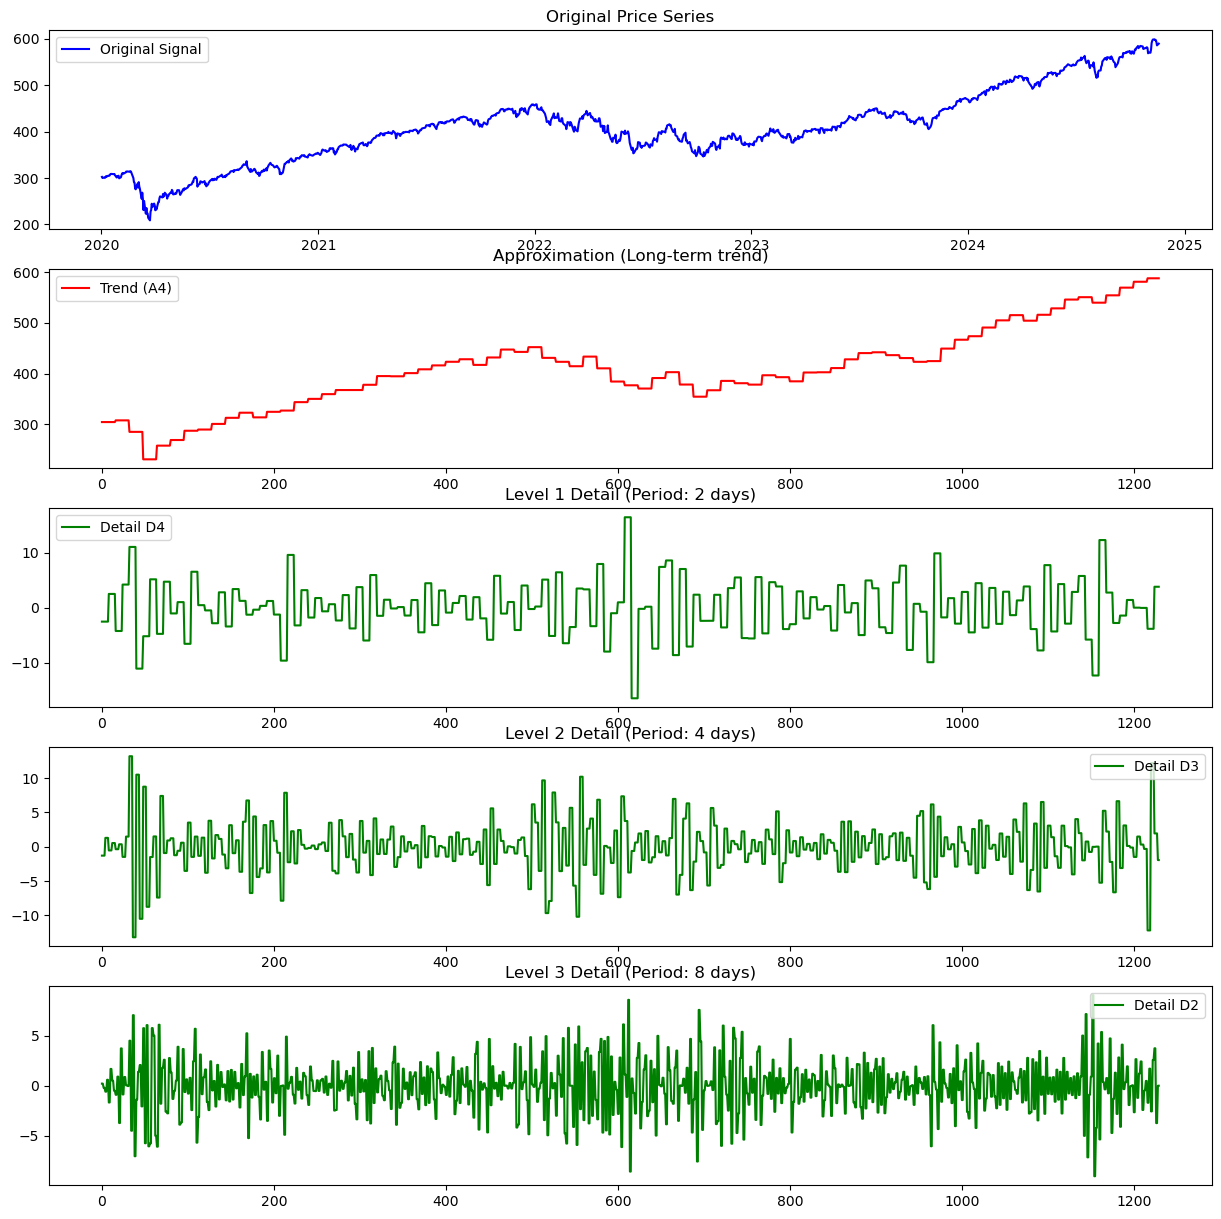

In [3]:
# Example usage
if __name__ == "__main__":
    # Initialize analyzer
    wa = WaveletAnalyzer()
    
    # Fetch data
    data = wa.fetch_data('SPY')
    
    # Perform decomposition
    coeffs = wa.decompose(wavelet='db1', level=4)
    
    # Reconstruct signals
    reconstructed = wa.reconstruct_by_level()
    
    # Plot decomposition
    wa.plot_decomposition("SPY Wavelet Decomposition")
    plt.show()
    
    # Analyze trading signals
    signals = wa.analyze_trading_signals()
    
    # Plot signals
    plt.figure(figsize=(15, 10))
    plt.plot(signals['Price'], label='Price')
    plt.plot(signals['Trend'], label='Trend', alpha=0.7)
    plt.scatter(signals.index[signals['Signal'] == 1], 
               signals['Price'][signals['Signal'] == 1],
               marker='^', color='g', label='Buy')
    plt.scatter(signals.index[signals['Signal'] == -1],
               signals['Price'][signals['Signal'] == -1],
               marker='v', color='r', label='Sell')
    plt.legend()
    plt.title('Trading Signals based on Wavelet Analysis')
    plt.show()